In [1]:
# noise vocoded speech

from __future__ import division, print_function
import numpy as np
from numpy import (arange, pi, zeros)
import scipy as sp
from scipy.io import wavfile
import scipy.signal
import matplotlib.pyplot as plt
import IPython
from IPython.display import display, Audio
import librosa
plt.style.use('bmh')
%matplotlib inline


In [7]:
fs, cheese = wavfile.read('audio.wav')
cheese = cheese.astype('float')

print('sampling frequency is {}'.format(fs))

sampling frequency is 16000


In [8]:
Audio(data=cheese, rate=fs)


In [14]:
# 定义一个 plot figure 方便一点
def plot_signal(x, fs):
    n = x.shape[-1]
    time = np.arange(n) / fs
    plt.plot(time, x,alpha=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    


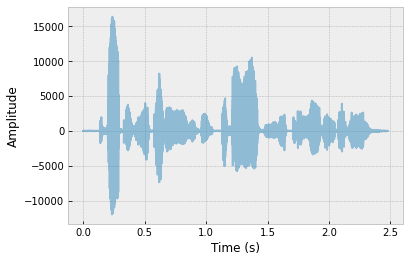

In [15]:
plot_signal(cheese, fs)


In [16]:
def third_octave_bounds(cf):
    third_octave_ratio = 2 ** (1/6)  # 2 * 1/6 = 1/3
    return np.array([cf / third_octave_ratio, cf * third_octave_ratio])


In [17]:
bounds = third_octave_bounds(1000)
'{:.2f} and {:.2f} Hz'.format(*bounds)


'890.90 and 1122.46 Hz'

In [18]:
def design_filter(bounds, fs):
    return sp.signal.butter(4, bounds * 2 / fs, btype='bandpass')


In [19]:
from scipy.signal import lfilter

def bandpass_filter(x, cf, fs):
    bounds = third_octave_bounds(cf)
    num, den = design_filter(bounds, fs)
    return lfilter(num, den, x)


In [20]:
# 滤波器 后的结果
y = bandpass_filter(cheese, 1000, fs)
Audio(y, rate=fs)


# The speech now sounds "narrow" and quieter.

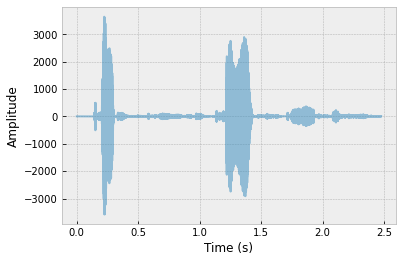

In [21]:
plot_signal(y, fs)

In [22]:
from IPython.html.widgets import interact, fixed
from IPython.display import display

def audio_bandpass_filtered_signal(x, cf, fs):
    y = bandpass_filter(x, cf, fs)
    display(Audio(y, rate=fs))


C:\ProgramData\Anaconda3\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [23]:
interact(audio_bandpass_filtered_signal, cf=(100, 6000, 500), x=fixed(cheese), fs=fixed(fs))


interactive(children=(IntSlider(value=2600, description='cf', max=6000, min=100, step=500), Output()), _dom_cl…

<function __main__.audio_bandpass_filtered_signal(x, cf, fs)>

In [24]:
def octave_spaced_frequencies(low, high):
    number_of_octaves = np.log2(high) - np.log2(low)
    return low * 2 ** arange(number_of_octaves)


In [52]:
octave_spaced_frequencies(100, 1000)

array([100., 200., 400., 800.])

In [30]:
def design_filterbank(center_frequencies, fs):
    boundaries = [third_octave_bounds(cf) for cf in center_frequencies]
    return [design_filter(bounds, fs) for bounds in boundaries]


In [31]:
center_frequencies = octave_spaced_frequencies(100, 201)
design_filterbank(center_frequencies, fs)

[(array([ 4.22328822e-10,  0.00000000e+00, -1.68931529e-09,  0.00000000e+00,
          2.53397293e-09,  0.00000000e+00, -1.68931529e-09,  0.00000000e+00,
          4.22328822e-10]),
  array([  1.        ,  -7.97008822,  27.79717258, -55.41104193,
          69.05072424, -55.08284116,  27.46886141,  -7.82930454,
           0.97651762])),
 (array([ 6.67800184e-09,  0.00000000e+00, -2.67120074e-08,  0.00000000e+00,
          4.00680110e-08,  0.00000000e+00, -2.67120074e-08,  0.00000000e+00,
          6.67800184e-09]),
  array([  1.        ,  -7.92796005,  27.52245933, -54.64623661,
          67.87314748, -54.00080055,  26.87615485,  -7.65035058,
           0.95358612]))]

In [44]:
def apply_filterbank(x, center_frequencies, fs):
    n_samples = x.shape[-1]
    n_channels = len(center_frequencies)
    
    coefficients = design_filterbank(center_frequencies, fs)
    y = zeros((n_channels, n_samples))
    for idx, (b, a) in enumerate(coefficients):
        y[idx] = lfilter(b, a, x)
    return y

In [47]:
center_frequencies = octave_spaced_frequencies(100, 1000)
y = apply_filterbank(cheese, center_frequencies, fs)
channel_index = 1
print('Channel centered at {} Hz'.format(center_frequencies[channel_index]))
Audio(y[channel_index], rate=fs)


Channel centered at 200.0 Hz


In [55]:
print(y.shape)
y = np.sum(y, axis=0)
print(y.shape)

(39629,)
()


In [49]:
Audio(y, rate=fs)

In [50]:
def compare_spectrogram(x, y, fs):
    """Plots spectrogram of x, the original, and y, the modified signal."""
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

    p_x, *_, im  = axes[0].specgram(x, cmap='Blues', Fs=fs)
    vmin, vmax = 10 * np.log10([np.min(p_x), np.max(p_x)])
    _ = axes[1].specgram(y, cmap='Blues', Fs=fs, vmin=vmin, vmax=vmax)
    axes[0].set_title('Original')
    axes[1].set_title('Modified')
    for ax in axes:
        ax.set_xlabel('Time (s)')
        ax.grid(False)
    axes[0].set_ylabel('Frequency (Hz)')
    cbar = fig.colorbar(im)
    cbar.ax.set_ylabel('Magnitude (dB)')
    fig.tight_layout()


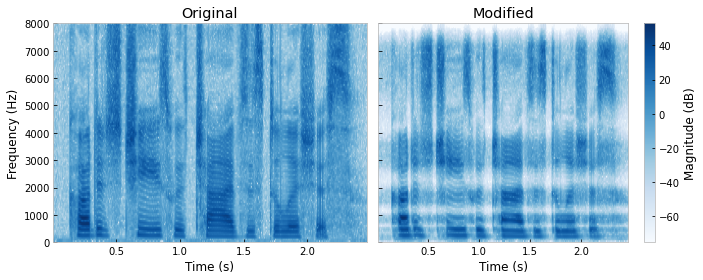

In [51]:
compare_spectrogram(cheese, y, fs)

In [23]:
highest_cutoff = third_octave_bounds(center_frequencies[-1])[-1]
'Highest cutoff frequency: {:.2f} Hz'.format(highest_cutoff)


'Highest cutoff frequency: 897.97 Hz'

As mentioned in the introduction, one of the goals of the vocoder design was to reduce the amount of information that had to be transmitted. In order to do so, the vocoder extracts the envelope of the signal, which means the shape of the slow fluctuations in the signal.



In [56]:
def extract_envelope(x, cutoff=20, order=1):
    envelope = np.abs(x)
    b, a = sp.signal.butter(order, cutoff * 2 / fs)
    low_pass_filtered_envelope = sp.signal.lfilter(b, a, envelope)
    return low_pass_filtered_envelope

# 提取低频震荡的 两种手法 应该是 
# 1 20hz的低筒滤波
# 2 那个技术的 

In [58]:
envelope = extract_envelope(cheese)
print(envelope.shape)

(39629,)


In [60]:
def plot_signal_and_envelope(x, envelope, fs):
    fig, ax = plt.subplots()
    t = arange(x.shape[-1]) / fs
    ax.plot(t, x, label='signal')
    ax.plot(t, envelope, label='envelope')
    ax.legend(loc='best')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')    


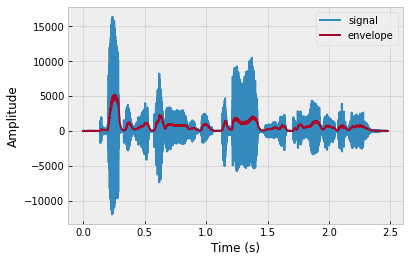

In [65]:
plot_signal_and_envelope(cheese, envelope, fs)

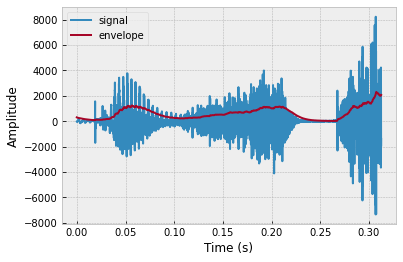

In [68]:
section = slice(5000, 10000)
plot_signal_and_envelope(cheese[section], envelope[section], fs)


In [62]:
def plot_cutoff_frequency_effect(cutoff):
    envelope = extract_envelope(cheese, cutoff=cutoff)
    plot_signal_and_envelope(cheese, envelope, fs)


In [63]:
interact(plot_cutoff_frequency_effect, cutoff=(1, 101, 5))


interactive(children=(IntSlider(value=51, description='cutoff', max=101, min=1, step=5), Output()), _dom_class…

<function __main__.plot_cutoff_frequency_effect(cutoff)>

In [69]:
# noise level how to control
noise = np.random.randn(*cheese.shape)

# 白噪声 特定区域？？ 


In [70]:
envelope = extract_envelope(cheese)
vocoded_noise = envelope * noise
Audio(data=vocoded_noise, rate=fs)


In [71]:
def vocode(x, center_frequencies, fs):
    n_channels = len(center_frequencies)
    n_samples = x.shape[-1]
    noise = np.random.randn(n_samples) 

    filtered_x = apply_filterbank(x, center_frequencies, fs)
    filtered_noise = apply_filterbank(noise, center_frequencies, fs)
    
    vocoded_noise = np.zeros((n_channels, n_samples))
    for idx, (x_band, noise_band) in enumerate(zip(filtered_x, filtered_noise)):
        envelope = extract_envelope(x_band)
        vocoded_noise[idx] = envelope * noise_band
    return np.sum(vocoded_noise, axis=0)


In [72]:
center_frequencies = octave_spaced_frequencies(100, 6000)
vocoded_cheese = vocode(cheese, center_frequencies, fs)
print('Vocoded speech with bands: {} Hz.'.format(center_frequencies))
Audio(vocoded_cheese, rate=fs)


Vocoded speech with bands: [ 100.  200.  400.  800. 1600. 3200.] Hz.


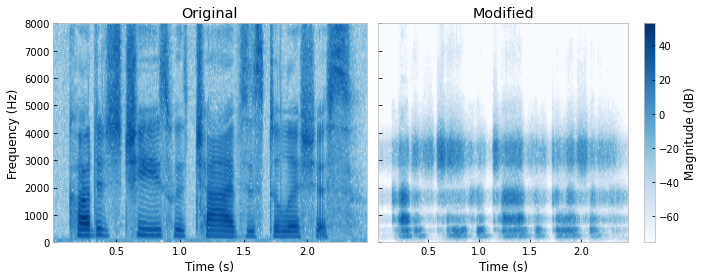

In [73]:
compare_spectrogram(cheese, vocoded_cheese, fs)

In [74]:
from collections import OrderedDict
from IPython.html.widgets import Checkbox


def create_cf_checkboxed(center_frequencies):
    center_frequency_checkboxes = {}
    for cf in center_frequencies:
        cf_string = '{}'.format(cf)
        center_frequency_checkboxes[cf_string] = Checkbox(True, description=cf_string)
    return center_frequency_checkboxes

def combine_center_frequencies(**kwargs):
    center_frequencies = np.array([float(cf) for cf, state in kwargs.items() if state])
    vocoded_cheese = vocode(cheese, center_frequencies, fs)
    cf_strings = ['{:.0f}'.format(cf) for cf in sorted(center_frequencies)]
    cf_string = ', '.join(cf_strings)
    compare_spectrogram(cheese, vocoded_cheese, fs)
    print('Speech vocoded with bands: {} Hz.'.format(cf_string))
    display(Audio(vocoded_cheese, rate=fs))


In [75]:
center_frequencies = octave_spaced_frequencies(100, 6001)
center_frequency_checkboxes = create_cf_checkboxed(center_frequencies)
interact(combine_center_frequencies, **center_frequency_checkboxes)


interactive(children=(Checkbox(value=True, description='100.0'), Checkbox(value=True, description='200.0'), Ch…

<function __main__.combine_center_frequencies(**kwargs)>

In [ ]:



# 已经完成了 noise vocoded 

# 尝试 mosaic speech 

# 第一步 滤波 
# try : gamma tone filterbank 
# try : octave filterbank

# 第二步 取包络，增加白噪音 / 加在包络上 

# 第三步 取包络 获取 平均

# 第四步 包络 切成 80ms 每段
## 通过用相同平均强度的带状噪声部分取代每个临界带的每个时间段。.
# 需要 每段一个 平均 替代成 原来的 amplitude-modulated signal
# perfect 
#

In [ ]:
# 